## 1. Imports, Settings, and Loading the Data

In [125]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly as px
from fredapi import Fred
import getpass
import statsmodels.api as sm # Time series components
from statsmodels.tsa.stattools import adfuller # Dickey-Fuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf # autocorrelations

In [6]:
pd.set_option("display.max_columns", None) # pd.reset_option("display.max_columns")
plt.style.use('ggplot') # set default plotting style
color_pal = plt.rcParams["axes.prop_cycle"].by_key()["color"] # list of colors from style

In [11]:
# prompt for API key
fred_key = getpass.getpass(prompt = 'API Key: ')

API Key:  ········


In [13]:
# search FRED for datasets
fred = Fred(api_key = fred_key)
fred.search('median house price', limit = 100)

,id,realtime_start,realtime_end,title,observation_start,observation_end,frequency,frequency_short,units,units_short,seasonal_adjustment,seasonal_adjustment_short,last_updated,popularity,notes
series id,,,,,,,,,,,,,,,
MSPUS,MSPUS,2024-12-02,2024-12-02,Median Sales Price of Houses Sold for the Unit...,1963-01-01,2024-07-01,Quarterly,Q,Dollars,$,Not Seasonally Adjusted,NSA,2024-10-24 09:01:02-05:00,90,None
MSPNHSUS,MSPNHSUS,2024-12-02,2024-12-02,Median Sales Price for New Houses Sold in the ...,1963-01-01,2024-10-01,Monthly,M,Dollars,$,Not Seasonally Adjusted,NSA,2024-11-26 09:03:04-06:00,67,None
HOSMEDUSM052N,HOSMEDUSM052N,2024-12-02,2024-12-02,Median Sales Price of Existing Homes,2023-10-01,2024-10-01,Monthly,M,Dollars,$,Not Seasonally Adjusted,NSA,2024-11-21 09:15:17-06:00,66,The National Association of Realtors monthly h...
MSPNHSUSA,MSPNHSUSA,2024-12-02,2024-12-02,Median Sales Price for New Houses Sold in the ...,1963-01-01,2023-01-01,Annual,A,Dollars,$,Not Seasonally Adjusted,NSA,2024-05-23 09:01:13-05:00,8,None
MEDLISPRIPERSQUFEEUS,MEDLISPRIPERSQUFEEUS,2024-12-02,2024-12-02,Housing Inventory: Median Listing Price per Sq...,2016-07-01,2024-10-01,Monthly,M,U.S. Dollars,U.S. $,Not Seasonally Adjusted,NSA,2024-10-31 16:51:03-05:00,55,The median listing price per square foot in a ...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
MEDLISPRIPERSQUFEE26820,MEDLISPRIPERSQUFEE26820,2024-12-02,2024-12-02,Housing Inventory: Median Listing Price per Sq...,2016-07-01,2024-10-01,Monthly,M,U.S. Dollars,U.S. $,Not Seasonally Adjusted,NSA,2024-10-31 16:47:04-05:00,7,The median listing price per square foot in a ...
MEDLISPRIPERSQUFEE33540,MEDLISPRIPERSQUFEE33540,2024-12-02,2024-12-02,Housing Inventory: Median Listing Price per Sq...,2016-07-01,2024-10-01,Monthly,M,U.S. Dollars,U.S. $,Not Seasonally Adjusted,NSA,2024-10-31 16:45:04-05:00,7,The median listing price per square foot in a ...
MEDLISPRIPERSQUFEE16980,MEDLISPRIPERSQUFEE16980,2024-12-02,2024-12-02,Housing Inventory: Median Listing Price per Sq...,2016-07-01,2024-10-01,Monthly,M,U.S. Dollars,U.S. $,Not Seasonally Adjusted,NSA,2024-10-31 16:49:06-05:00,7,The median listing price per square foot in a ...


In [19]:
# pull dataset from FRED
df_houseprice = 
df_houseprice

1963-01-01     17800.0
1963-04-01     18000.0
1963-07-01     17900.0
1963-10-01     18500.0
1964-01-01     18500.0
                ...   
2023-07-01    435400.0
2023-10-01    423200.0
2024-01-01    426800.0
2024-04-01    414500.0
2024-07-01    420400.0
Length: 247, dtype: float64

In [67]:
# convert to a dataframe
df_houseprice = (fred.get_series(series_id = 'MSPUS')
                 .to_frame()
                 .reset_index()
                 .rename(columns = {'index': 'Date', 0: 'Price'})
                 .query("Date >= '2000-01-01'")
                 .reset_index(drop = True)
                )
df_houseprice

,Date,Price
0,2000-01-01,165300.0
1,2000-04-01,163200.0
2,2000-07-01,168800.0
3,2000-10-01,172900.0
4,2001-01-01,169800.0
...,...,...
94,2023-07-01,435400.0
95,2023-10-01,423200.0
96,2024-01-01,426800.0
97,2024-04-01,414500.0


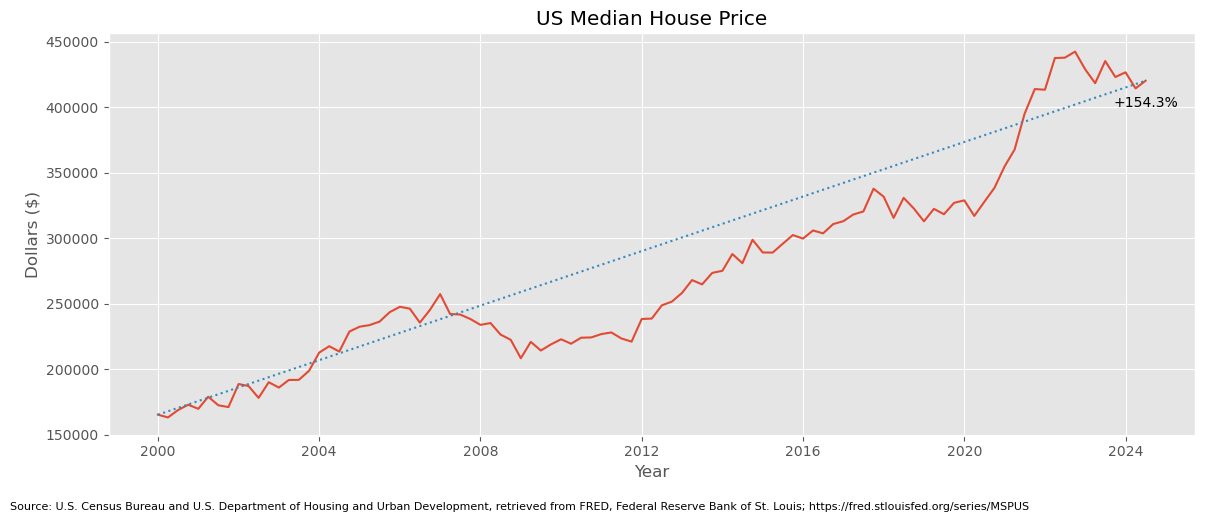

In [75]:
plt.figure(figsize = (12, 5))

first_date = df_houseprice.Date.min()
last_date = df_houseprice.Date.max()
date_x = [first_date, last_date]

first_price = df_houseprice.Price.iloc[0]
last_price = df_houseprice.Price.iloc[-1]
price_y = [first_price, last_price]

# Plot house price
plt.plot(df_houseprice.Date, df_houseprice.Price) # (x, y) coords

# Plot price change line
plt.plot(date_x, price_y, linestyle = 'dotted') # (x, y) coords

# Price change label
percent_change = ((last_price / first_price - 1) * 100). round(1)
plt.annotate(
    text = f'+{percent_change}%',
    xy = (last_date, last_price),
    xytext = (last_date, last_price - 20000),
    ha = 'center'
)

# Set title and labels
plt.ylabel('Dollars ($)')
plt.xlabel('Year')
plt.title('US Median House Price')
plt.figtext(0, -0.03, 'Source: U.S. Census Bureau and U.S. Department of Housing and Urban Development, retrieved from FRED, Federal Reserve Bank of St. Louis; https://fred.stlouisfed.org/series/MSPUS', size=8)
plt.tight_layout()
plt.show()

## 2. Decomposition

In [ ]:
df_houseprice.set_index('Date', inplace = True)

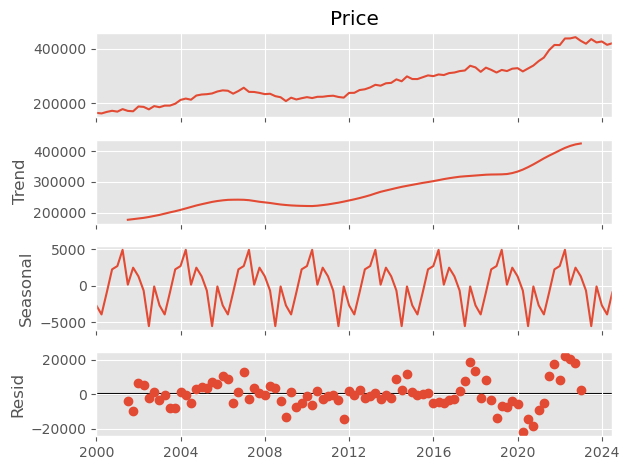

In [90]:
decomposition = sm.tsa.seasonal_decompose(df_houseprice.Price, model='additive', period = 12)
decomposition.plot()
plt.show()

- The data trends upwards over time
- There exists seasonality in the data
- Noise can be seen in periods outside factors such as 2008 recession and 2020 Covid
- This data can be considered as non-stationary as there is an upward trend and seasonality

## 3. Checking for Stationarity

In [102]:
# Conduct Dickey-Fuller test to check for stationarity
def dickey_fuller(timeseries):
    print('Dickey-Fuller Stationarity Test:')
    test = adfuller(timeseries, autolag = 'AIC')
    result = pd.Series(test[0:4], index = ['Test Statistic', 'p-value', 'Number of Lags Used', 'Number of Observations Used'])
    for key, value in test[4].items():
        result['Critical Value (%s)'%key] = value

    print(result)

dickey_fuller(df_houseprice.Price)

Dickey-Fuller Stationarity Test:
Test Statistic                 -0.350326
p-value                         0.918068
Number of Lags Used             3.000000
Number of Observations Used    95.000000
Critical Value (1%)            -3.501137
Critical Value (5%)            -2.892480
Critical Value (10%)           -2.583275
dtype: float64


Null Hypothesis (H0): The house price time series has a unit root (non-stationary)

Alternative Hypothesis (H1): The time series does not have a unit root (stationary)

Since the p-value is high (0.918) and the test statistic is not smaller than the critical values at any significance level, we fail to reject the null hypthoesis.
This means that the time series does not appear to be stationary (it likely has a unit root and is non-stationary)

## 4. Stationarizing the Data

In [107]:
# Differencing techinique
df_houseprice_1 = df_houseprice - df_houseprice.shift(1)
df_houseprice_1.dropna(inplace = True)

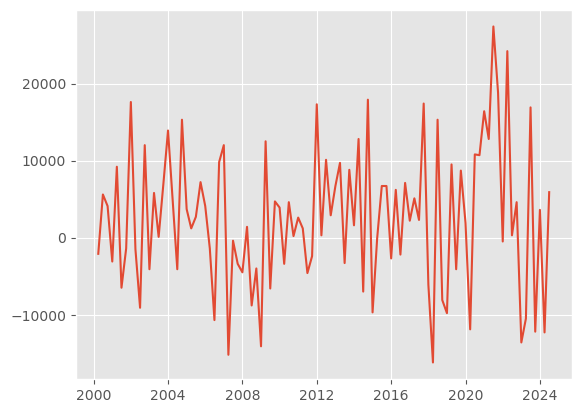

In [109]:
plt.plot(df_houseprice_1)

In [111]:
dickey_fuller(df_houseprice_1.Price)

Dickey-Fuller Stationarity Test:
Test Statistic                 -4.026845
p-value                         0.001276
Number of Lags Used             2.000000
Number of Observations Used    95.000000
Critical Value (1%)            -3.501137
Critical Value (5%)            -2.892480
Critical Value (10%)           -2.583275
dtype: float64


Null Hypothesis (H0): The house price time series has a unit root (non-stationary)

Alternative Hypothesis (H1): The time series does not have a unit root (stationary)

The p-value (0.001) is much smaller than 0.05, indicating strong evidence against the null hypothesis. Based on these results, we reject the nul hypothesis.  The time series is stationary.

## 5. Autocorrelations

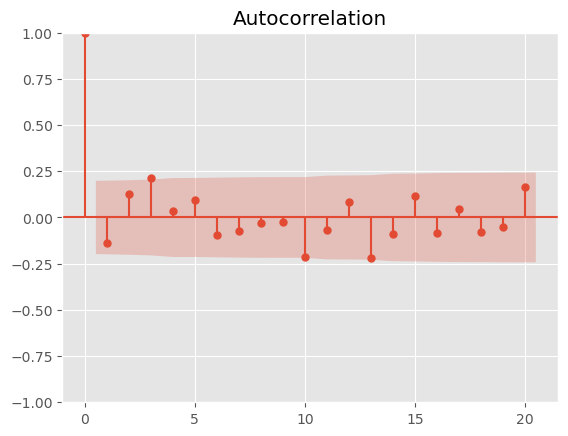

In [127]:
plot_acf(df_houseprice_1)
plt.show()